# Project 2: Student Dropout Classifier
*by Anna Kohnen & Marco Aigner*

In this project we develop and evaluate different models to identify students who are at risk of dropping out of university. 

## The Tasks
The project comprises 6 tasks, listed as follows:

1. To analyze and explore the dataset. To perform data pre-processing and cleansing.
2. To calculate and visualize the correlation of features among each other and with the labels. To discuss an intersting correlation
3. To train (at least) four machine-learning algorithms: One probabilistic, one tree-based, one distance-based and one ensemble method each.
4. To evaluate the models using k-fold cross-validation. To report accuracy, mean standard deviation and a confusion matrix per model. To discuss whether one model is significantly better than the others
5. To pick two favorite models. To discuss which features were most relevant for the students' success. To discuss differences between the two models
6. So export the best performing model as ONNX to compete against other models

## The Data
The dataset contains data from students from the Polytechnic Institute of Portalegre and was published by [Martins et al.](https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16). It explicitly only includes information known at the time of students' enrollment and comprises features related to their academic path as well as to demographical and social-economic information.

There are both numerical and categorical features included in the dataset.

<div class="alert alert-block alert-info"> <b>Caution:</b> The categorical features are encoded as numbers.</div>

# Libraries
The following four libraries are allowed for this project:

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

# Importing the Data

In [34]:
student_data = pd.read_csv('./student_data.csv', delimiter=',')

# 1. Exploring and Pre-Processing
We first look at the data's shape:

In [35]:
student_data.shape

(4000, 37)

There is data on 4000 students across 37 columns each.

Taking a closer look at the columns:

In [36]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4000 non-null   int64  
 1   Application mode                                4000 non-null   int64  
 2   Application order                               4000 non-null   int64  
 3   Course                                          4000 non-null   int64  
 4   Daytime/evening attendance	                     4000 non-null   int64  
 5   Previous qualification                          4000 non-null   int64  
 6   Previous qualification (grade)                  4000 non-null   float64
 7   Nacionality                                     4000 non-null   int64  
 8   Mother's qualification                          4000 non-null   int64  
 9   Father's qualification                   

## 1.1 Pre-Processing
We can verify that **1.** there are 36 features and one target variable and **2.** that categorical features are numerically encoded.

For convenience and readabiltiy, we transform the column names into ```snake_case```

In [37]:
# create a list of new column names by replacing spaces and '/' with _ and removing the rest
snake_case_columns = student_data.columns.map(lambda x: x.lower().replace(' ', '_').replace('/','_').replace('(','').replace(')', '').replace('\t', '').replace('\'s','')).to_list()
student_data.rename(columns=dict(zip(student_data.columns, snake_case_columns)), inplace=True) # apply the snake_case column names

## 1.2 General Exploration
We fix a typo that we noticed:

In [38]:
student_data.rename(columns={'nacionality':'nationality'}, inplace=True)

Now let's inspect some rows of data:

In [39]:
student_data.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Are there any data missing?

In [40]:
student_data.isnull().values.any()

False

There seem to be no empty cells in the dataframe.

Are there duplicates within the data?

In [41]:
student_data.isna().values.any()

False

There does not seem to be duplicate data present.

## 1.3 Statistical Exploration

Statistics might provide us further insight into the features.
We use different measures for continuous and categorical features.
We distinguish programmatically between the two by assigning the ``categorical`` dtype to categorical features.

We know that there are both continuous and discrete features within the dataset. Using the [documentation](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) we can manually extract a list of categorical columns: 

In [42]:
# manually create a list of categorical column names
categorical_columns = ['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nationality', 'mother_qualification', 'father_qualification', 'mother_occupation', 'father_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'international']

# assign the categorical dtype to respective columns
student_data[categorical_columns] = student_data[categorical_columns].astype('category')

Pandas ``describe()``-method provides useful statistics such as the count, mean, minimum and maximum values as well as the standard deviation and percentiles of the distributions.

Now that we assigned categorical columns, the method summarizes only numerical features

In [43]:
student_data.describe()

,admission_grade,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000
mean,127.055000,23.328250,0.694250,6.246500,8.272000,4.678500,10.624771,0.136250,0.53125,6.21425,8.030750,4.410500,10.201676,0.14950,11.559675,1.221725,-0.007977
std,14.438823,7.691865,2.320692,2.434999,4.155458,3.069771,4.844416,0.671043,1.87694,2.15859,3.925705,2.991024,5.229377,0.73945,2.673214,1.383045,2.271051
min,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,7.600000,-0.800000,-4.060000
25%,118.000000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.00000,5.00000,6.000000,2.000000,10.750000,0.00000,9.400000,0.300000,-1.700000
50%,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.00000,6.00000,8.000000,5.000000,12.200000,0.00000,11.100000,1.400000,0.320000
75%,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.381295,0.000000,0.00000,7.00000,10.000000,6.000000,13.333333,0.00000,13.900000,2.600000,1.790000
max,190.000000,70.000000,20.000000,23.000000,45.000000,21.000000,18.875000,12.000000,19.00000,23.00000,28.000000,20.000000,17.714286,12.00000,16.200000,3.700000,3.510000


Using ``describe`` on categorical columns gives us different statistics, such as the number of unique as well as the most frequent variable

In [44]:
student_data.describe(include=['category'])

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,mother_occupation,father_occupation,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,international
count,4000,4000,4000,4000,4000,4000,4000.0,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000
unique,6,18,8,17,2,17,97.0,20,28,32,30,43,2,2,2,2,2,2,2
top,1,1,1,9500,1,1,133.1,1,1,37,9,9,1,0,0,1,0,0,0
freq,3538,1540,2734,675,3550,3368,435.0,3899,971,1115,1430,923,2186,3955,3538,3522,2596,3006,3899


## 1.4 Visual Exploration
### 1.4.1 Target Variables

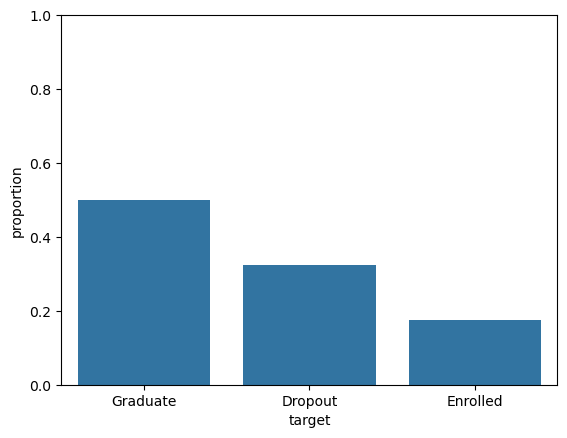

In [45]:
label_distribution = student_data.value_counts(subset=student_data['target'], normalize=True)

fig, ax = plt.subplots()
sns.barplot(data=label_distribution)
ax.set_ylim(0, 1)
plt.show()

### 1.4.2 Continuous Features
<div class="alert alert-block alert-danger">Ich glaube es macht Sinn zuerst die Korrelationen zu überprüfen bevor wir alle Features plotten. Dann können wir nämlich Features mit schwacher Korrelation zum Target raus schmeißen und sparen uns Arbeit beim plotten.</div>

# 2. Correlation Analysis

## 2.1 Features With The Target
We are interested in how much each feature correlates with the target. Features with a very low correlation likely do not provide significant information for our prognosis and therefore can be omitted. On the other hand, in our interpretation we can focus on highly correlated features instead.

First, we numerically encode the target column:

In [46]:
student_data['target'] = student_data['target'].map(arg={'Dropout':0, 'Enrolled':1, 'Graduate':2})


Then we calculate the pairwise correlations:

In [47]:
# TODO: try out different correlation methods (kendall, spearman, ...)
# However, spearman should be the way to go if we don't assume normal distributions
corr_feature_target = student_data.corrwith(other=student_data['target'], axis='index', drop=False, method='spearman')

corr_feature_target.sort_values(ascending=True)

age_at_enrollment                              -0.281150
debtor                                         -0.244022
gender                                         -0.225779
application_mode                               -0.209917
previous_qualification                         -0.118788
marital_status                                 -0.103684
curricular_units_2nd_sem_without_evaluations   -0.083841
curricular_units_1st_sem_without_evaluations   -0.080199
curricular_units_1st_sem_evaluations           -0.032583
mother_qualification                           -0.028701
inflation_rate                                 -0.026871
educational_special_needs                      -0.017074
nationality                                     0.005437
international                                   0.005793
course                                          0.014656
curricular_units_1st_sem_credited               0.017472
unemployment_rate                               0.019362
father_qualification           

- The correlation tell us how much each feature influences the target variable.
- Closer to 0 = less correlation with 0 = no  correlation
- Closer to 1/-1 more positive/negative correlation

We only focus on features that are highly correlated with the target. For this, we define a treshhold by which we filter:

In [48]:
CORRELATION_TRESHHOLD= 0.05

corr_feature_target = corr_feature_target[abs(corr_feature_target) >= CORRELATION_TRESHHOLD]
corr_feature_target.sort_values(ascending=True)

age_at_enrollment                              -0.281150
debtor                                         -0.244022
gender                                         -0.225779
application_mode                               -0.209917
previous_qualification                         -0.118788
marital_status                                 -0.103684
curricular_units_2nd_sem_without_evaluations   -0.083841
curricular_units_1st_sem_without_evaluations   -0.080199
daytime_evening_attendance                      0.074854
application_order                               0.096947
previous_qualification_grade                    0.110508
displaced                                       0.119914
admission_grade                                 0.121395
curricular_units_1st_sem_enrolled               0.228297
curricular_units_2nd_sem_enrolled               0.240103
scholarship_holder                              0.301234
tuition_fees_up_to_date                         0.401018
curricular_units_1st_sem_grade 

- Successfully reduced number of features
- TODO: Some interpretations of the correlations e.g. how lower age could lead to higher chances of graduation or how scholarship holders are more likely to graduate

## 2.2 Features With Each Other
- Multiple features with a high correlation among each other do not add information to the model
- Identify such groups of features
- Pick only the one with the highest correlation with the target

First calculate the correlation matrix using only the features with a high correlation with the target

In [49]:
df_corr_target = student_data[corr_feature_target.index]

correlations_features = df_corr_target.corr()

correlations_features

,marital_status,application_mode,application_order,daytime_evening_attendance,previous_qualification,previous_qualification_grade,admission_grade,displaced,debtor,tuition_fees_up_to_date,...,age_at_enrollment,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,target
marital_status,1.000000,0.261939,-0.131257,-0.277134,0.054593,-0.023270,-0.005418,-0.237198,0.036537,-0.090468,...,0.524302,0.051979,-0.033323,-0.060006,0.037561,0.038756,-0.043414,-0.068877,0.023787,-0.089571
application_mode,0.261939,1.000000,-0.283972,-0.309523,0.419315,-0.035087,-0.006727,-0.307690,0.125699,-0.137212,...,0.515380,0.166762,-0.029649,-0.114627,0.044231,0.130965,-0.074652,-0.116219,0.049564,-0.215868
application_order,-0.131257,-0.283972,1.000000,0.160947,-0.184557,-0.066802,-0.099785,0.334146,-0.067976,0.054946,...,-0.273215,-0.015484,0.036226,0.056414,-0.032414,0.032017,0.072377,0.053198,-0.011667,0.080808
daytime_evening_attendance,-0.277134,-0.309523,0.160947,1.000000,-0.075680,0.057419,0.010328,0.255752,0.004889,0.037135,...,-0.465119,-0.040645,0.019159,0.063485,0.045178,0.003817,0.036965,0.049349,-0.003986,0.076438
previous_qualification,0.054593,0.419315,-0.184557,-0.075680,1.000000,0.104619,0.185478,-0.107672,0.092565,-0.069417,...,0.146929,0.085901,0.027144,-0.000535,0.007066,0.061123,-0.007294,0.000587,0.007863,-0.053294
previous_qualification_grade,-0.023270,-0.035087,-0.066802,0.057419,0.104619,1.000000,0.574714,-0.011624,-0.038001,0.053100,...,-0.111772,-0.031419,0.044701,0.054539,-0.008207,-0.030423,0.050026,0.050406,-0.026515,0.100577
admission_grade,-0.005418,-0.006727,-0.099785,0.010328,0.185478,0.574714,1.000000,-0.000008,-0.013615,0.046252,...,-0.028662,-0.042772,0.062484,0.067559,0.001399,-0.049531,0.068658,0.069515,-0.022116,0.116002
displaced,-0.237198,-0.307690,0.334146,0.255752,-0.107672,-0.011624,-0.000008,1.000000,-0.098170,0.105624,...,-0.368038,-0.063909,0.054939,0.073288,-0.018593,-0.038705,0.073488,0.078349,-0.035188,0.120427
debtor,0.036537,0.125699,-0.067976,0.004889,0.092565,-0.038001,-0.013615,-0.098170,1.000000,-0.416651,...,0.103363,-0.004139,-0.104599,-0.105371,0.009387,-0.024999,-0.149247,-0.143489,0.061285,-0.246173
tuition_fees_up_to_date,-0.090468,-0.137212,0.054946,0.037135,-0.069417,0.053100,0.046252,0.105624,-0.416651,1.000000,...,-0.175679,0.064522,0.242891,0.249968,-0.050395,0.092633,0.299254,0.299885,-0.081870,0.410423


- Filter to only keep absolute correlations above a given treshhold 

In [50]:
correlations_features_filtered = correlations_features[abs(correlations_features) > 0.4]
correlations_features_filtered

,marital_status,application_mode,application_order,daytime_evening_attendance,previous_qualification,previous_qualification_grade,admission_grade,displaced,debtor,tuition_fees_up_to_date,...,age_at_enrollment,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,target
marital_status,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.524302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_mode,NaN,1.000000,NaN,NaN,0.419315,NaN,NaN,NaN,NaN,NaN,...,0.515380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_order,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daytime_evening_attendance,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.465119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_qualification,NaN,0.419315,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_qualification_grade,NaN,NaN,NaN,NaN,NaN,1.000000,0.574714,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_grade,NaN,NaN,NaN,NaN,NaN,0.574714,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
displaced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debtor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.416651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tuition_fees_up_to_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.416651,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.410423


- Plot the remaining correlations

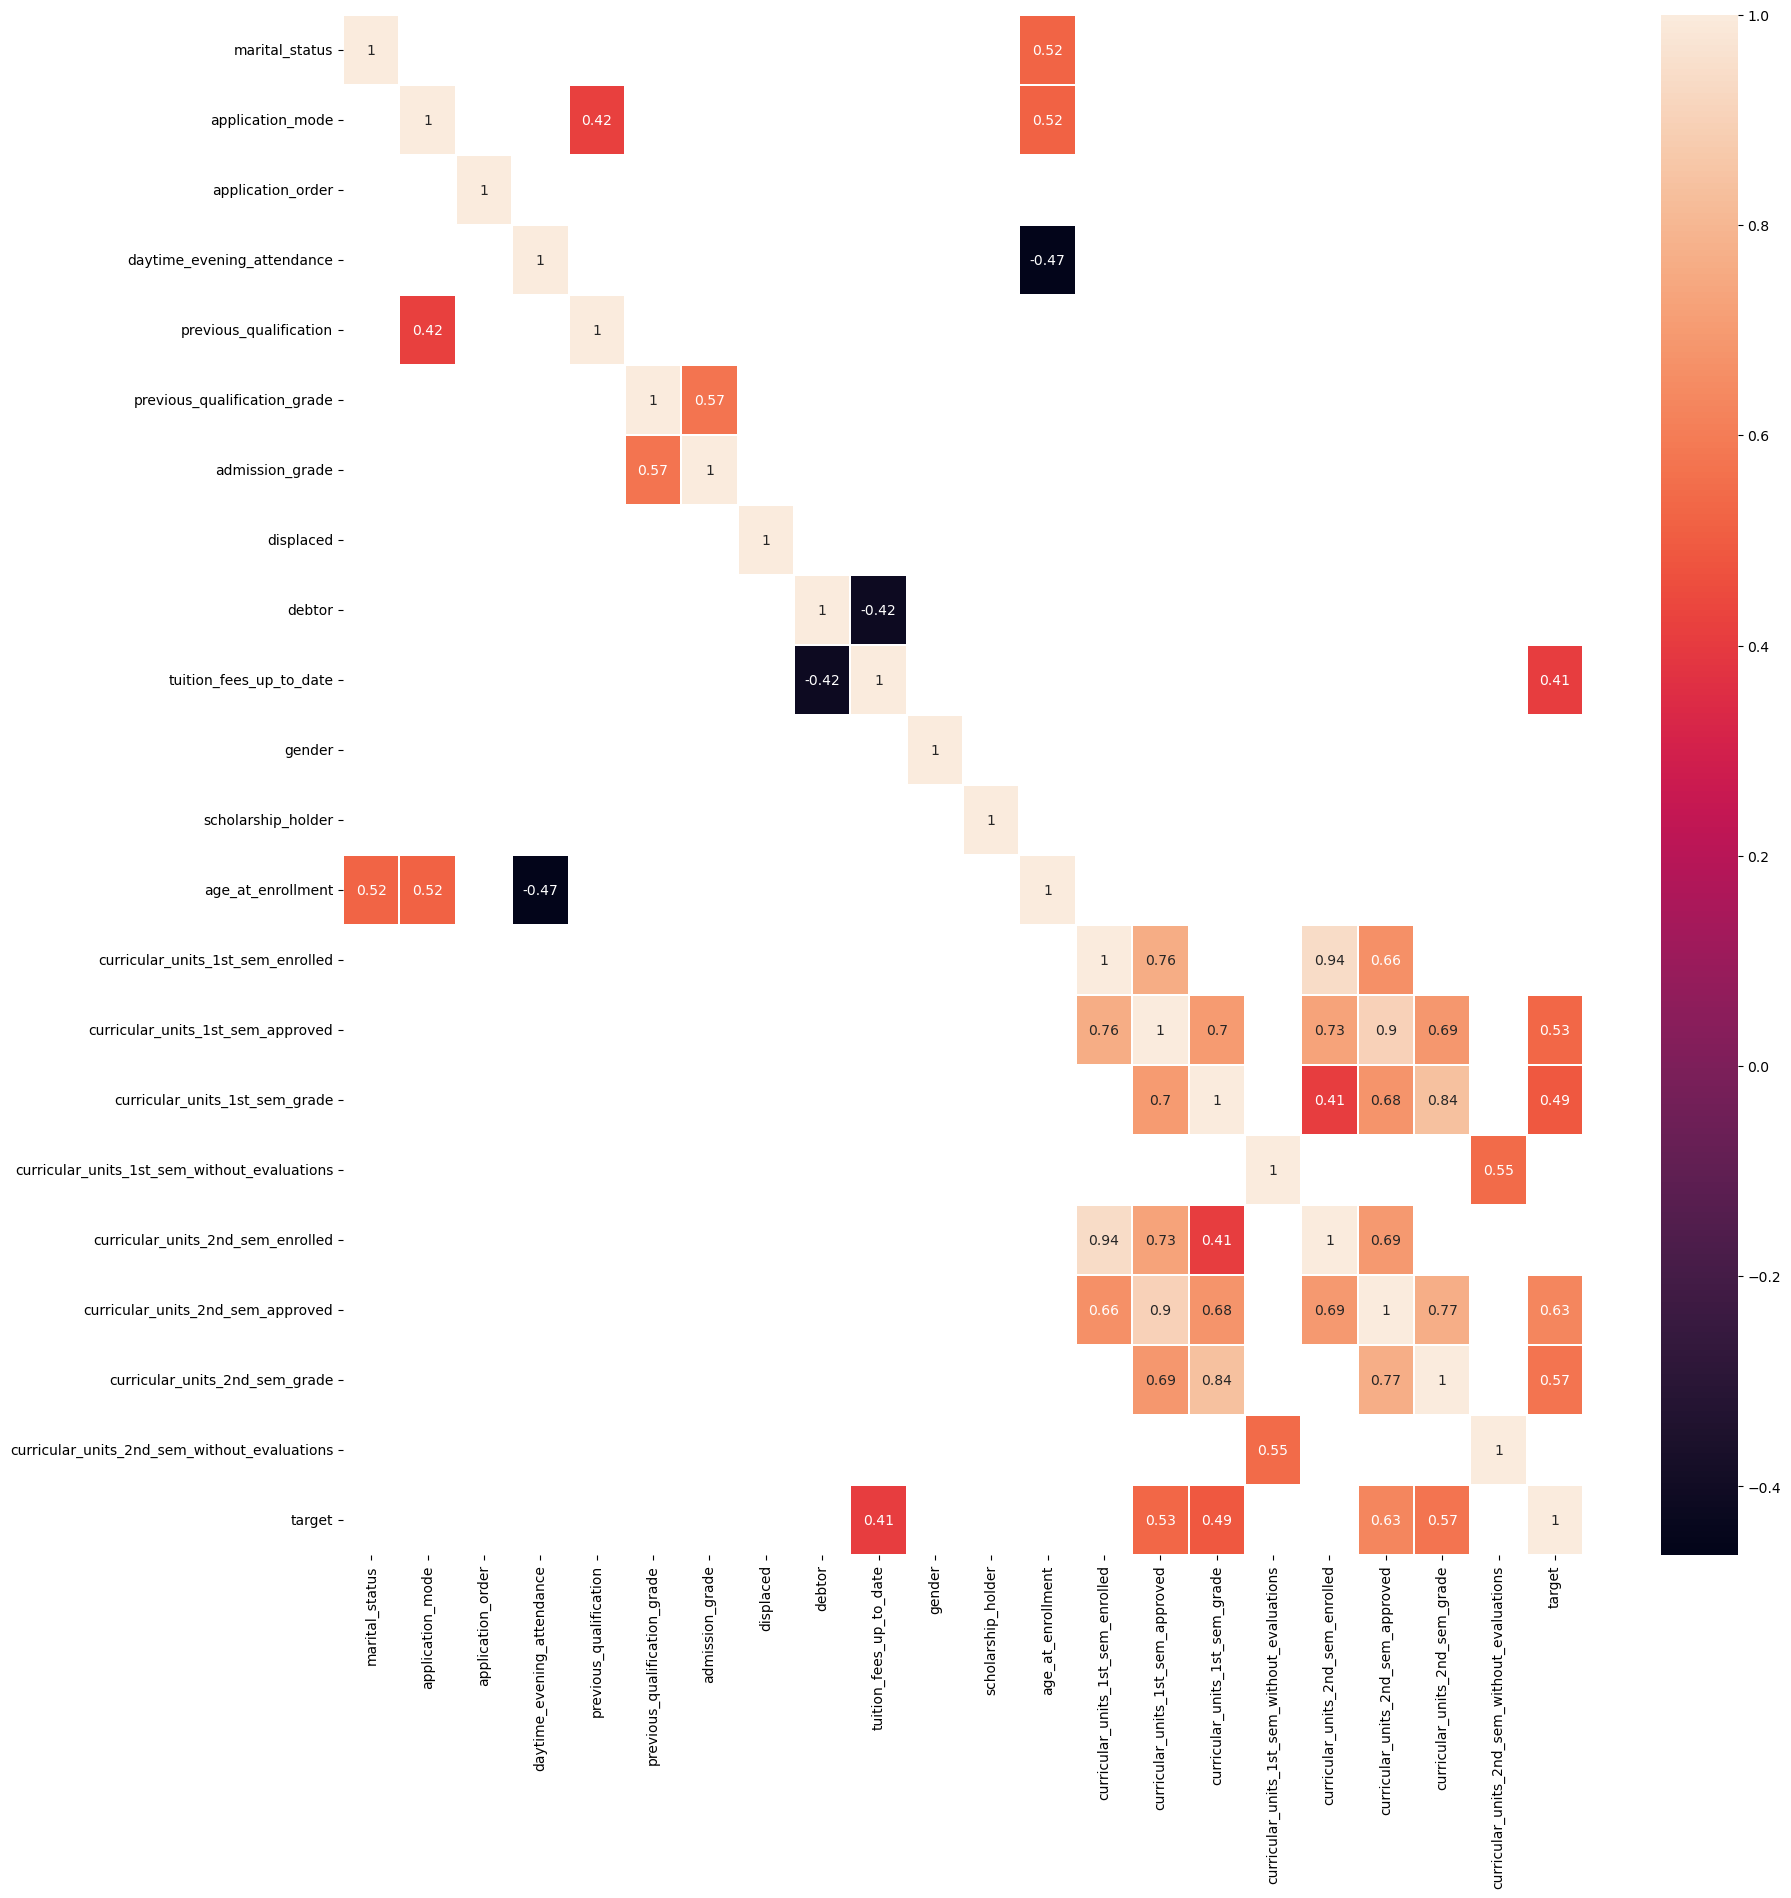

In [51]:
plt.figure(figsize=(20,20))
sns.heatmap(data=correlations_features_filtered, annot=True, linewidths=0.1)

plt.show()

- Discuss how the age at enrollment is correlated with the marital status, the application mode and daytime/evening-attendance

- Of a group of correlated features, only pick one (the one with the highest correlation with the target)

<div class="alert alert-block alert-info">Hardcoded for now. Maybe automate later</div>

In [52]:
#to_drop = ['marital_status', 'application_mode', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'debtor', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations' ]

In [53]:
#final_dataframe = df_corr_target.drop(columns=to_drop, axis='columns')

#final_dataframe

# 3. Model Training

## 3.1 Data Split

In [54]:
final_dataframe = df_corr_target

In [55]:
from sklearn.model_selection import train_test_split

final_dataframe

X = final_dataframe.drop(columns='target')
y = final_dataframe['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

<hr>

# Random dataset for test and train -> but does not perform as good as the normal train_test_split() function

In [56]:
TRAIN_FRACTION = 0.75

train = pd.concat([final_dataframe[final_dataframe['target'] == 0].sample(frac=TRAIN_FRACTION), final_dataframe[final_dataframe['target'] == 1].sample(frac=TRAIN_FRACTION),final_dataframe[final_dataframe['target'] == 2].sample(frac=TRAIN_FRACTION)])
test = final_dataframe.drop(train.index)
#X_train = test.drop(columns='target')
#y_train = test['target']
#X_test = test.drop(columns='target')
#y_test = test['target']

<hr>

# Create the models

<hr>

In [57]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold


from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

# Probabilistic Model
probabilistic_model = GaussianNB()

# Tree-based Model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Distance-Based Model
knn = KNeighborsClassifier(n_neighbors=5)

# Ensemble Methods
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgbc = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

models = {
    'Gaussian Naive Bayes': GaussianNB(),

    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),

    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),

    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Specify the number of folds for K-fold cross-validation
num_folds = 10

# Create KFold objects
folds = {
    'K-Fold' : KFold(n_splits=num_folds, shuffle=True, random_state=42),
    'Stratified K-Fold' : StratifiedKFold(n_splits=num_folds)
}



In scikit-learn, the KNeighborsClassifier expects the input data to be in the form of a NumPy array or array-like object, not a DataFrame.

This is why we call ".values" on our input data

<hr>

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Specify the number of folds for K-fold cross-validation
num_folds = 10

# Create a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can adjust the random_state for reproducibility
skf = StratifiedKFold(n_splits=10)
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

for model_name, model in models.items(): 
    feature_importance = None 
    
    model.fit(X_train.values,y_train.values)
    
    # Perform K-fold cross-validation and get accuracy scores for each fold
    kf_scores = cross_val_score(model, X_train.values, y_train.values, cv=kf, scoring='accuracy')
    print(f"K-Fold with model: {model_name} - Accuracy: {np.mean(kf_scores):.4f} (± {np.std(kf_scores):.4f})")

    skf_scores = cross_val_score(model, X_train.values, y_train.values, cv=skf, scoring='accuracy')
    print(f"Stratified K-Fold with model: {model_name} - Accuracy: {np.mean(skf_scores):.4f} (± {np.std(skf_scores):.4f})")
    
    rkf_scores = cross_val_score(model, X_train.values, y_train.values, cv=rkf, scoring='accuracy')
    print(f"Repeated K-Fold with model: {model_name} - Accuracy: {np.mean(rkf_scores):.4f} (± {np.std(rkf_scores):.4f})")


    # Assuming 'model' is your trained model and X_test, y_test are your test data
    y_pred = cross_val_predict(model, X_train, y_train, cv=kf)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    
    try:
        # Check if the model has feature_importances_ attribute
        if hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_

    except Exception as e:
        print(f"Error while processing {model_name}: {e}")

    print(f"\nModel: {model_name}")
    if feature_importance is not None:
        feature_dict = {}
        for feature, importance in zip(X_train.columns, feature_importance):
            feature_dict[feature] = importance
            #print(f"{feature}: {importance:.4f}" + "\n")

        # Sort the dictionary by values in ascending order
        sorted_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))
        print(sorted_dict)
        print("\n")
    else:
        print("Feature importance not available for this model." + "\n")


    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(final_dataframe["target"].unique()), yticklabels=sorted(final_dataframe["target"].unique(), reverse=True))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



<hr>

# Method to train the model

In [58]:
def train_model(model, X_train, y_train):
    try:
        # Train the model
        model.fit(X_train.values, y_train.values)
    except Exception as e:
        print(f"Error while training {model_name}: {e}")

<hr>

<hr>

# Methode for evaluating the model
## AKTUELL NICHT GENUTZT

In [59]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
def evaluate_model(model, X, y):
    # Specify the number of folds for K-fold cross-validation
    num_folds = 10

    # Create KFold objects
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    skf = StratifiedKFold(n_splits=num_folds)
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=2, random_state=42)

    # Evaluate the model using different cross-validation methods
    for cv_method, cv_object in [("K-Fold", kf), ("Stratified K-Fold", skf), ("Repeated K-Fold", rkf)]:
        scores = cross_val_score(model, X.values, y.values, cv=cv_object, scoring='accuracy')
        print(f"{cv_method} with {model_name} - Accuracy: {np.mean(scores):.2f} (± {np.std(scores):.2f})")


<hr>

<hr>

# Method for cross validation prediction

In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def cross_validate_model(model, X, y, folding):
    try:
        # Use cross_val_predict to get predictions for each fold
        y_pred = cross_val_predict(model, X.values, y.values, cv=folding)

        # Calculate confusion matrix
        cm = confusion_matrix(y, y_pred)
        #print(f"Confusion Matrix with {fold_name}:\n{cm}")

        # Calculate accuracy
        accuracy = accuracy_score(y, y_pred)
        print(f"{fold_name} with method cross_val_predict and model: {model_name} - Accuracy: {accuracy:.2f}\n")

        print(f"Classification Report with cross-val-predict for {model_name} and {fold_name} folding:\n")
        print(classification_report(y, y_pred) + "\n")

        return cm

    except Exception as e:
        print(f"Error while cross-validating {model_name}: {e}")
        return None

<hr>

<hr>

# Method to plot confusion Matrix

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(model_name, cm_dict, labels):

    # Set the number of rows and columns for the subplots
    num_rows = 1
    num_cols = len(cm_dict)
    
    # Set the figure size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    # Flatten the axes if only one row
    axes = axes.flatten() if num_rows == 1 else axes

    # Iterate through the dictionary items and create subplots
    for idx, (title, matrix) in enumerate(cm_dict.items()):
        ax = axes[idx]
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # Set the title for the entire plot
    plt.suptitle(model_name)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

    # Plot confusion matrix using seaborn
    #plt.figure(figsize=(5, 3))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    #plt.title('Confusion Matrix')
    #plt.xlabel('Predicted')
    #plt.ylabel('Actual')
    #plt.show()


<hr>

<hr>

# Methode to get feature importance

In [63]:
def analyze_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_dict = dict(zip(X.columns, feature_importance))

    # Sort the dictionary by values in ascending order
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))
    print(sorted_dict)
    print("\n")

<hr>

<hr>

# Methode that does everything (fit, evaluate (cross-validation), feature importance, plot confusion matrix)

In [64]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate_model(model, X, y, X_train, y_train, cv):
    try:
        # Train the model
        train_model(model, X_train, y_train)

        # Perform K-fold cross-validation and get accuracy scores for each fold
        cv_scores = cross_val_score(model, X.values, y.values, cv=cv, scoring='accuracy')
        print(f"{fold_name} with method cross_val_score and model: {model_name} - Accuracy: {np.mean(cv_scores):.2f} (± {np.std(cv_scores):.2f})\n")

        conf_mat = cross_validate_model(model, X, y, cv)
        
        if conf_mat is not None:
            # Check if the model has feature_importances_ attribute
            if hasattr(model, 'feature_importances_'):
                analyze_feature_importance(model, X)
            else:
                print(f"Feature importance not available for {model_name} with {fold_name} folding." + "\n")

    except Exception as e:
        print(f"Error while processing {model_name}: {e}")
        
    return conf_mat

<hr>

<hr>

# Execute everything for each model

K-Fold with method cross_val_score and model: Gaussian Naive Bayes - Accuracy: 0.69 (± 0.02)

K-Fold with method cross_val_predict and model: Gaussian Naive Bayes - Accuracy: 0.69

Classification Report with cross-val-predict for Gaussian Naive Bayes and K-Fold folding:

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1292
           1       0.36      0.17      0.23       705
           2       0.72      0.87      0.79      2003

    accuracy                           0.69      4000
   macro avg       0.61      0.58      0.58      4000
weighted avg       0.66      0.69      0.67      4000


Feature importance not available for Gaussian Naive Bayes with K-Fold folding.

Stratified K-Fold with method cross_val_score and model: Gaussian Naive Bayes - Accuracy: 0.70 (± 0.01)

Stratified K-Fold with method cross_val_predict and model: Gaussian Naive Bayes - Accuracy: 0.70

Classification Report with cross-val-predict for Gaussian Naive

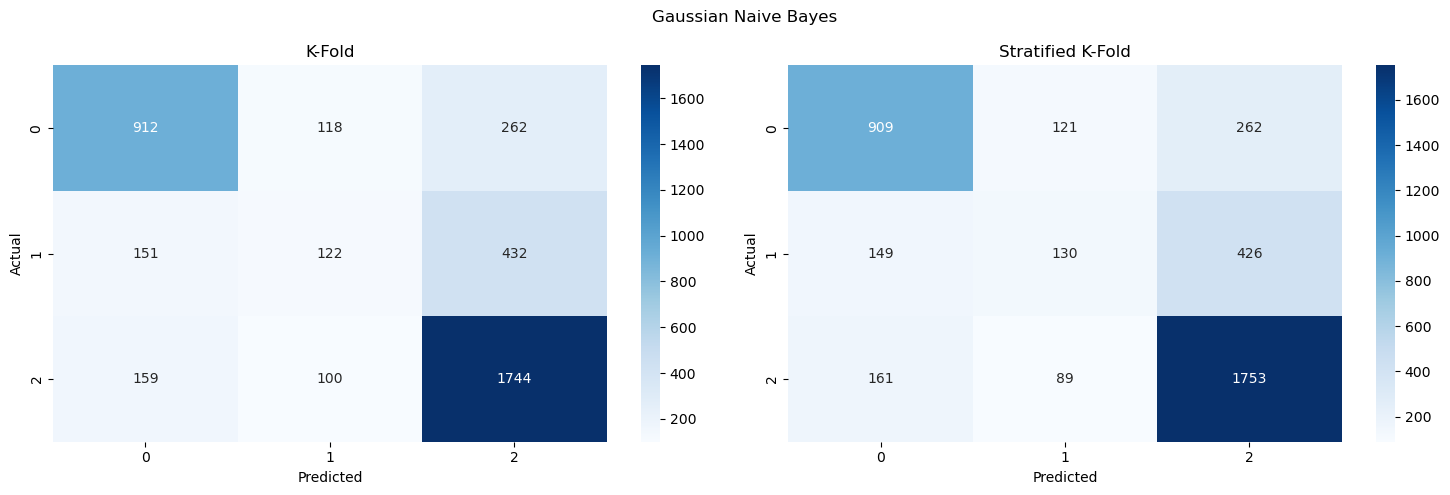

K-Fold with method cross_val_score and model: Random Forest - Accuracy: 0.77 (± 0.01)

K-Fold with method cross_val_predict and model: Random Forest - Accuracy: 0.77

Classification Report with cross-val-predict for Random Forest and K-Fold folding:

              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1292
           1       0.53      0.32      0.40       705
           2       0.79      0.93      0.85      2003

    accuracy                           0.77      4000
   macro avg       0.71      0.67      0.68      4000
weighted avg       0.75      0.77      0.75      4000


{'curricular_units_2nd_sem_approved': 0.16720236441412847, 'curricular_units_2nd_sem_grade': 0.13382965165396205, 'curricular_units_1st_sem_approved': 0.1154340264976369, 'curricular_units_1st_sem_grade': 0.11009268052111716, 'admission_grade': 0.07538824483376488, 'previous_qualification_grade': 0.06632071252422206, 'age_at_enrollment': 0.05735086998316711, 'appli

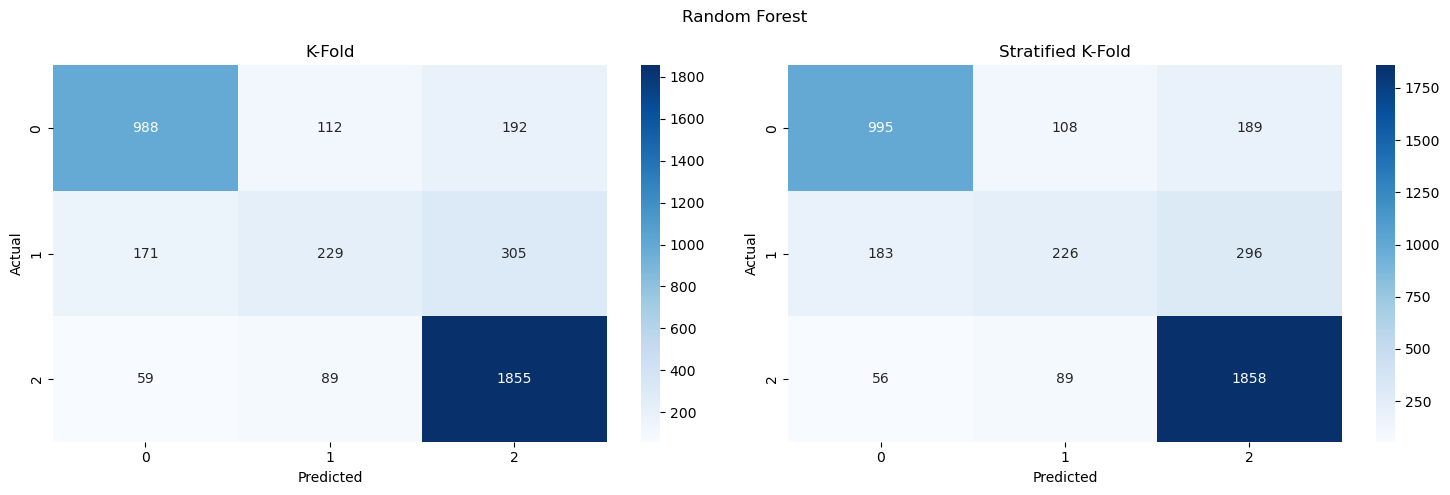

K-Fold with method cross_val_score and model: K-Nearest Neighbors - Accuracy: 0.66 (± 0.02)

K-Fold with method cross_val_predict and model: K-Nearest Neighbors - Accuracy: 0.66

Classification Report with cross-val-predict for K-Nearest Neighbors and K-Fold folding:

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1292
           1       0.34      0.23      0.27       705
           2       0.71      0.81      0.76      2003

    accuracy                           0.66      4000
   macro avg       0.57      0.56      0.56      4000
weighted avg       0.63      0.66      0.64      4000


Feature importance not available for K-Nearest Neighbors with K-Fold folding.

Stratified K-Fold with method cross_val_score and model: K-Nearest Neighbors - Accuracy: 0.66 (± 0.01)

Stratified K-Fold with method cross_val_predict and model: K-Nearest Neighbors - Accuracy: 0.66

Classification Report with cross-val-predict for K-Nearest Neighbors 

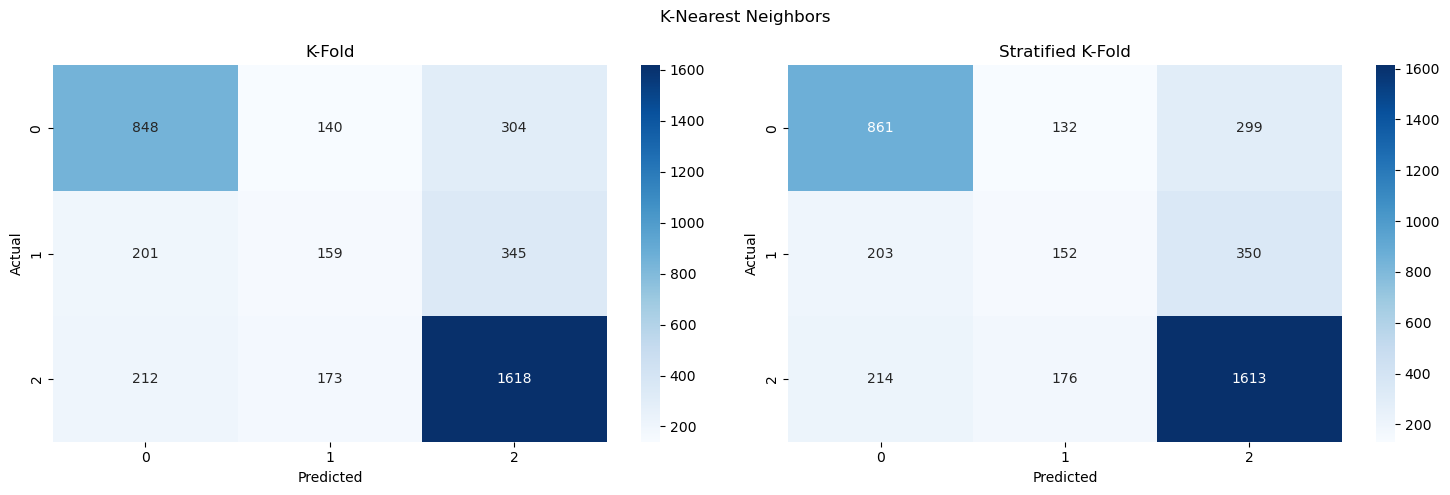

K-Fold with method cross_val_score and model: Gradient Boosting - Accuracy: 0.77 (± 0.02)

K-Fold with method cross_val_predict and model: Gradient Boosting - Accuracy: 0.77

Classification Report with cross-val-predict for Gradient Boosting and K-Fold folding:

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1292
           1       0.52      0.35      0.42       705
           2       0.80      0.92      0.86      2003

    accuracy                           0.77      4000
   macro avg       0.71      0.68      0.69      4000
weighted avg       0.76      0.77      0.76      4000


{'curricular_units_2nd_sem_approved': 0.5023425447915861, 'curricular_units_2nd_sem_grade': 0.07413158784969576, 'curricular_units_1st_sem_grade': 0.059072863680484276, 'tuition_fees_up_to_date': 0.0567531036188731, 'curricular_units_1st_sem_approved': 0.055886996081283086, 'age_at_enrollment': 0.043457917472771855, 'curricular_units_1st_sem_enrolled': 

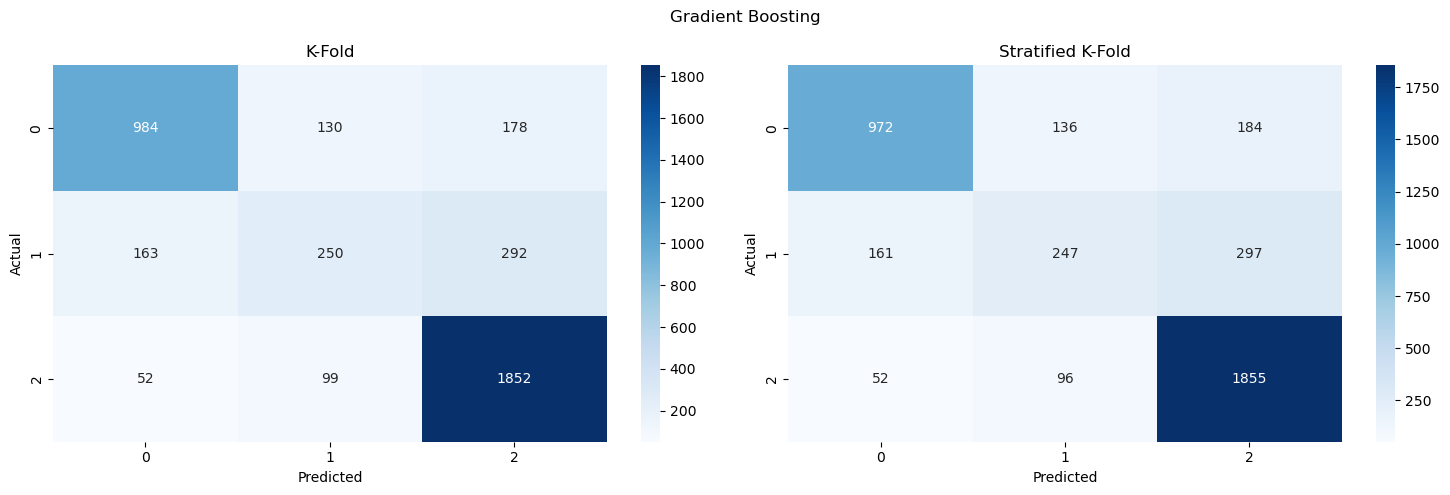

K-Fold with method cross_val_score and model: XGBoost - Accuracy: 0.76 (± 0.02)

K-Fold with method cross_val_predict and model: XGBoost - Accuracy: 0.76

Classification Report with cross-val-predict for XGBoost and K-Fold folding:

              precision    recall  f1-score   support

           0       0.80      0.75      0.78      1292
           1       0.49      0.35      0.40       705
           2       0.80      0.91      0.85      2003

    accuracy                           0.76      4000
   macro avg       0.70      0.67      0.68      4000
weighted avg       0.75      0.76      0.75      4000


{'curricular_units_2nd_sem_approved': 0.29257387, 'tuition_fees_up_to_date': 0.11652413, 'curricular_units_1st_sem_enrolled': 0.06301437, 'scholarship_holder': 0.05419349, 'curricular_units_2nd_sem_enrolled': 0.042984605, 'application_mode': 0.035484266, 'debtor': 0.03520364, 'curricular_units_1st_sem_approved': 0.03232602, 'curricular_units_1st_sem_without_evaluations': 0.03029366,

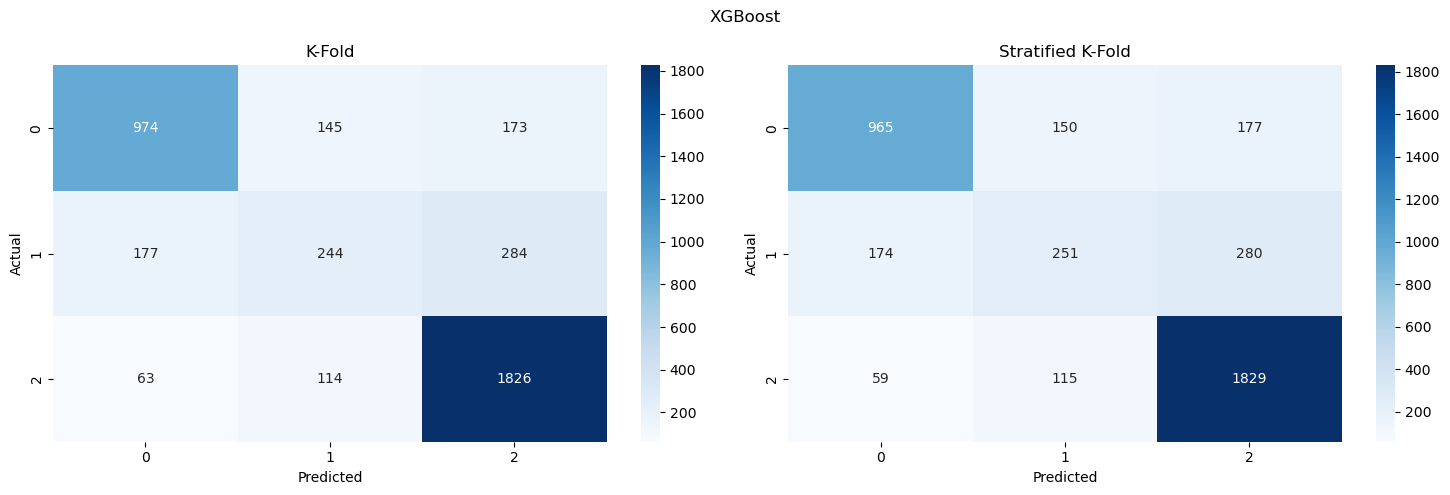

In [65]:

# Specify the number of folds for K-fold cross-validation
num_folds = 10

TRAIN_FRACTION = 0.75
train = pd.concat([final_dataframe[final_dataframe['target'] == 0].sample(frac=TRAIN_FRACTION), final_dataframe[final_dataframe['target'] == 1].sample(frac=TRAIN_FRACTION),final_dataframe[final_dataframe['target'] == 2].sample(frac=TRAIN_FRACTION)])
test = final_dataframe.drop(train.index)
X_train = test.drop(columns='target')
y_train = test['target']
#X_test = test.drop(columns='target')
#y_test = test['target']

# Loop through your models and call the train_and_evaluate_model method
for model_name, model in models.items():
    cm_dict = {}
    for fold_name, fold in folds.items():
        cm_dict[fold_name] = train_and_evaluate_model(model, X, y, X_train, y_train, fold)

    # Plot confusion matrix using seaborn
    plot_confusion_matrix(model_name, cm_dict, sorted(final_dataframe["target"].unique()))


PCA, ein random feature nehmen, gini co efficient(rfc), multiple linear regression